In [ ]:
!pip install fabio
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import fabio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 14.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function to preprocess Fabio images
def load_and_preprocess_fabio_images(directory_path, size=(200, 200), limit=200):
    images = []
    try:
        for i, filename in enumerate(os.listdir(directory_path)):
            if i >= limit:
                break
            if filename.endswith(".cbf"):
                file_path = os.path.join(directory_path, filename)
                img = fabio.open(file_path)
                image = img.data

                # Resize to the desired size
                width, height = size
                zoom_factor_x = width / image.shape[1]
                zoom_factor_y = height / image.shape[0]
                img_resized = zoom(image, (zoom_factor_y, zoom_factor_x))

                # Clip intensities and normalize
                img_resized = np.clip(img_resized, a_min=0, a_max=100)
                img_normalized = img_resized / 100.0

                images.append(img_normalized)

        if len(images) == 0:
            raise ValueError(f"No images found in directory: {directory_path}")

        return np.array(images)

    except Exception as e:
        print(f"Error loading and preprocessing images: {e}")
        return None


In [ ]:
def load_and_preprocess_fabio_images(directory_path, limit=200):
    images = []
    try:
        for i, filename in enumerate(os.listdir(directory_path)):
            if i >= limit:
                break
            if filename.endswith(".cbf"):
                file_path = os.path.join(directory_path, filename)
                img = fabio.open(file_path)
                image = img.data

                # Initialize the list to store crops
                crops = []

                # Centered Crop
                center_x = (image.shape[1] - 800) // 2
                center_y = (image.shape[0] - 700) // 2
                centered_crop = image[center_y:center_y + 700, center_x:center_x + 800]
                crops.append(centered_crop)

                # Upper Left Crop
                upper_left_crop = image[0:700, 0:800]
                crops.append(upper_left_crop)

                # Random Crop
                x_start = random.randint(0, image.shape[1] - 800)
                y_start = random.randint(0, image.shape[0] - 700)
                random_crop = image[y_start:y_start + 700, x_start:x_start + 800]
                crops.append(random_crop)

                # Normalize crops and add to images list
                for crop in crops:
                    crop = np.clip(crop, a_min=0, a_max=100)
                    normalized_crop = crop / 100.0
                    images.append(normalized_crop)

        if len(images) == 0:
            raise ValueError(f"No images found in directory: {directory_path}")

        return np.array(images)

    except Exception as e:
        print(f"Error loading and preprocessing images: {e}")
        return None

In [ ]:
# Plotting function
def plot_images(images, labels, size=10):
    plt.figure(figsize=(20, size))
    for i in range(size):
        plt.subplot(size // 5, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

In [ ]:
# Define paths for data
input_directory_dots = "/content/drive/MyDrive/stuff3"
input_directory_rings = "/content/drive/MyDrive/stuff4"
input_directory_blank = "/content/drive/MyDrive/metal2"

In [ ]:
width, height = 200, 200
images_dots = load_and_preprocess_fabio_images(input_directory_dots, size=(width, height), limit=200)
images_rings = load_and_preprocess_fabio_images(input_directory_rings, size=(width, height), limit=200)
images_blank = load_and_preprocess_fabio_images(input_directory_rings, size=(width, height), limit=200)

In [ ]:
# Create labels
labels_dots = np.zeros(len(images_dots), dtype=int)  # Label 0 for dots
labels_rings = np.ones(len(images_rings), dtype=int)  # Label 1 for rings
labels_blank = np.ones(len(images_blank), dtype=int)

# Combine data
images = np.concatenate((images_dots, images_rings, images_blank), axis=0)
labels = np.concatenate((labels_dots, labels_rings, labels_blank), axis=0)

# Split dataset
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42
)

# Reshape data for the CNN
train_images = train_images.reshape(-1, width, height, 1)
test_images = test_images.reshape(-1, width, height, 1)


In [ ]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_images, train_labels,
    epochs=20,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 1.0000 - loss: 6.3417e-05 - val_accuracy: 1.0000 - val_loss: 9.9965e-06
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 1.0000 - loss: 2.0790e-04 - val_accuracy: 1.0000 - val_loss: 9.8538e-06
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 1.0000 - loss: 5.0610e-05 - val_accuracy: 1.0000 - val_loss: 1.1953e-05
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 1.0000 - loss: 1.9376e-04 - val_accuracy: 1.0000 - val_loss: 1.1814e-05
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 1.0000 - loss: 1.5503e-04 - val_accuracy: 1.0000 - val_loss: 9.9432e-06
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 1.0000 - loss: 2.0369e-04 - val_accuracy: 1.0000 - val_loss: 9.6899e-06
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 1.0000 - loss: 5.1284e-05 - val_accuracy: 1.0000 - val_loss: 1.0422e-05
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 1.0000 - loss: 3

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 552ms/step - accuracy: 1.0000 - loss: 1.0237e-05
Test Accuracy: 100.00%


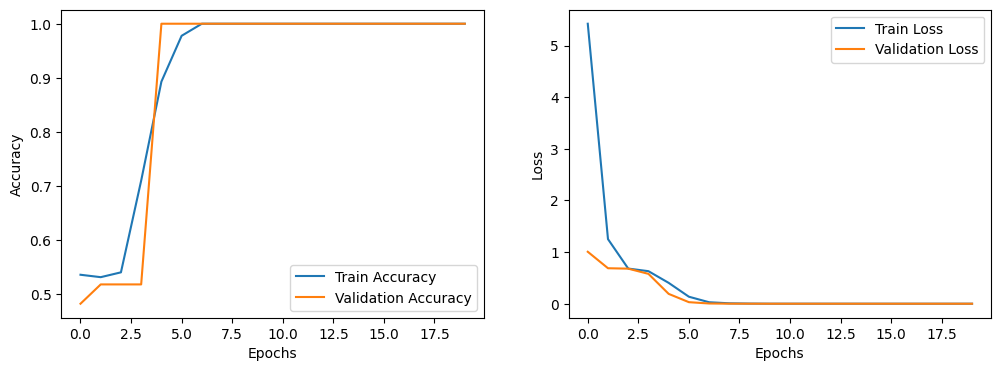

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 918ms/step


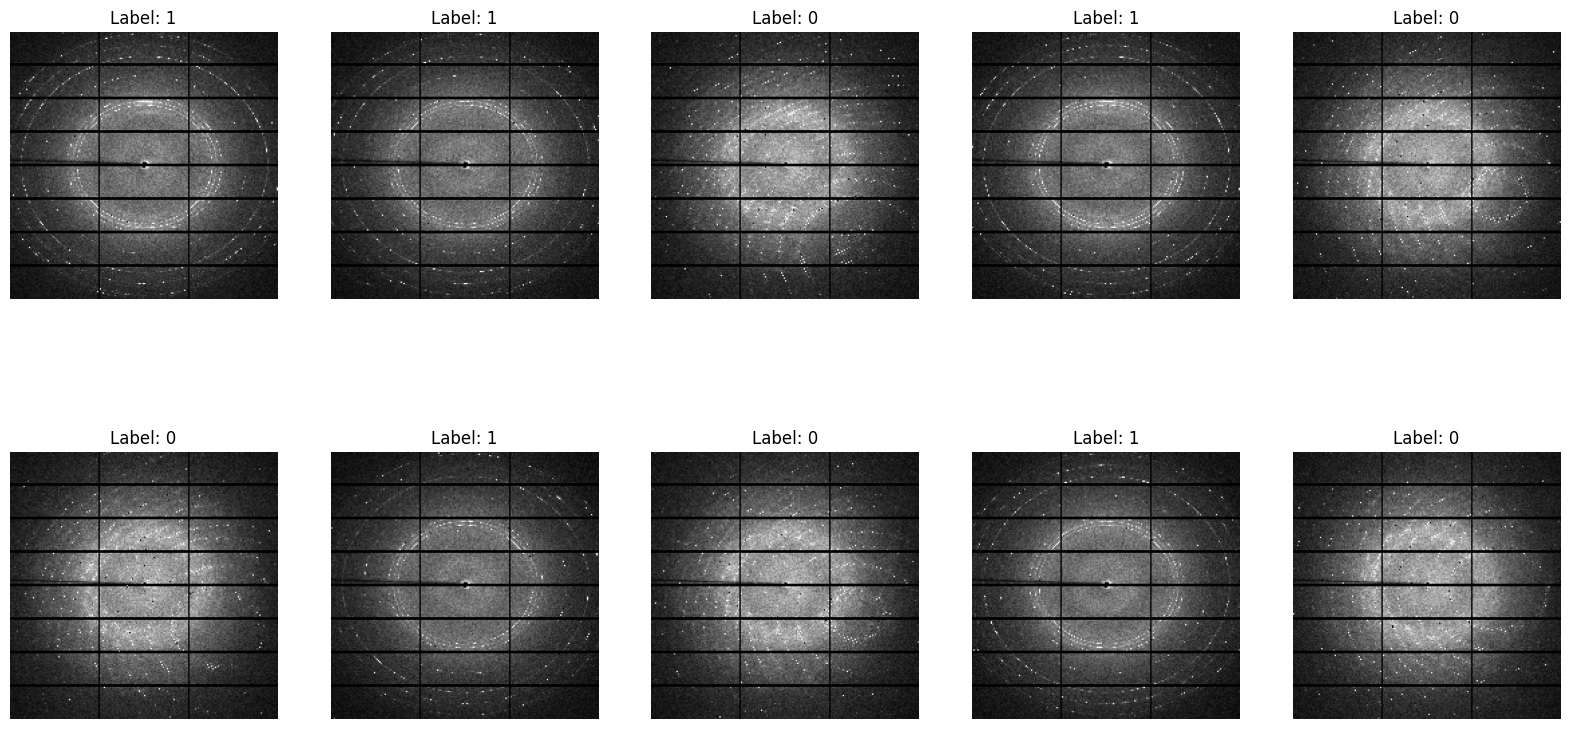

In [ ]:
# Visualize some predictions
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
plot_images(test_images.squeeze(), predicted_labels, size=10)
